In [1]:
# mount gdrive

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/ANDL/Homework_1

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/ANDL/Homework_1


In [2]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import adam_v2

import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow.keras as tfk
import random
import os
import tensorflow as tf
from PIL import Image

In [3]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [4]:
# Dataset folders 
dataset_dir = 'atMost700'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

labels = ['Species1','Species2','Species3','Species4','Species5','Species6','Species7','Species8',]

Text(0.5, 1.0, 'Number of training images per category:')

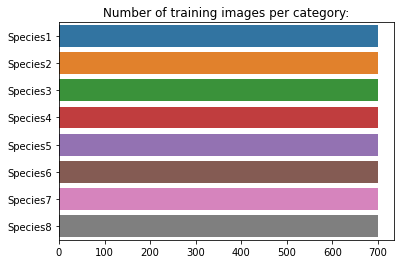

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
category_names = sorted(os.listdir(training_dir))
nb_categories = len(category_names)
img_pr_cat = []
for category in category_names:
    folder = training_dir + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per category:")

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(#rotation_range=180,
                                        height_shift_range=5,
                                        width_shift_range=5,
                                        #zoom_range=0.5,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        #fill_mode='nearest',
                                        preprocessing_function = preprocess_input,
                                        # rescale=1/255. not on vgg16
                                        ) 
valid_data_gen = ImageDataGenerator(#rescale=1/255.,
                                    preprocessing_function = preprocess_input)
test_data_gen = ImageDataGenerator(#rescale=1/255.,
                                   preprocessing_function = preprocess_input)

In [7]:
# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=32,
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=True,
                                               seed=seed)
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                             target_size=(96,96),
                                             color_mode='rgb',
                                             classes=None, # can be set to labels
                                             class_mode='categorical',
                                             batch_size=32,
                                             shuffle=False,
                                             seed=seed)

Found 5600 images belonging to 8 classes.
Found 527 images belonging to 8 classes.
Found 361 images belonging to 8 classes.


In [8]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch

(Input) image shape: (32, 96, 96, 3)
Target shape: (32, 8)

Categorical label: [0. 0. 0. 0. 0. 0. 1. 0.]
Label: 6
Class name: Species7


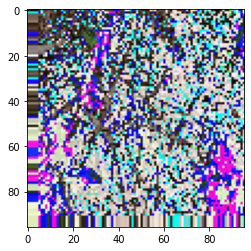

In [9]:
# Get a sample from dataset and show info
_ = get_next_batch(aug_train_gen)

In [10]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('data_augmentation_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback  = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 24, 24, 128)       0     

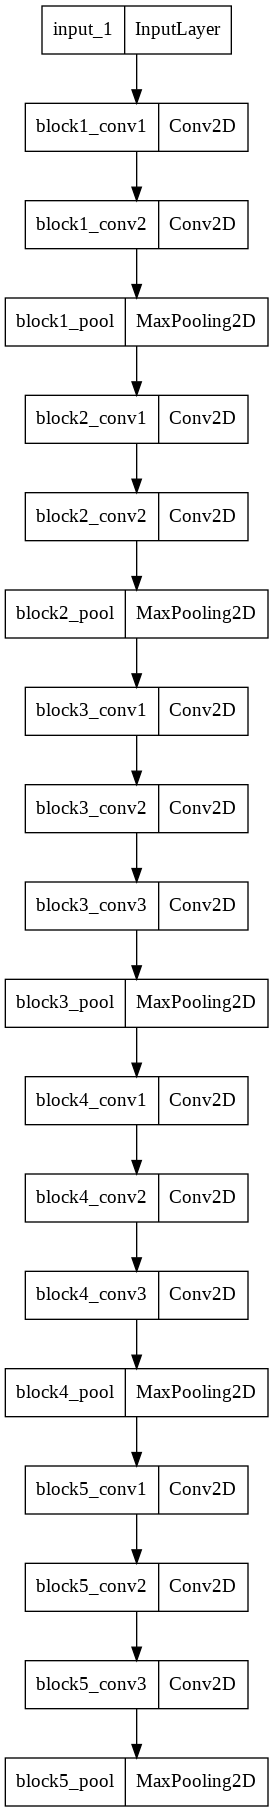

In [11]:
# Download and plot the VGG16 model
supernet = tfk.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3)
)
supernet.summary()
tfk.utils.plot_model(supernet)

In [12]:
input_shape = (96, 96, 3)
epochs = 200

In [13]:
import tensorflow.keras.layers as tfkl

# Use the supernet as feature extractor
supernet.trainable = False

inputs = tfk.Input(shape=(96,96,3))
# No resize
#x = tfkl.Resizing(64, 64, interpolation="bicubic")(inputs)
x = supernet(inputs)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(x)



# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=output_layer, name='model')

# Compile the model
tl_model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 256)               1179904   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 Output (Dense)              (None, 8)                 2056  

In [14]:
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   layer.trainable = False

for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [15]:
# Train the model
tl_callbacks = create_folders_and_callbacks(model_name = 'transfer_learning')

# Train the model
tl_history = tl_model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = tl_callbacks,
    #class_weight=class_weight
).history

Epoch 1/200
175/175 [==============================] - ETA: 0s - loss: 3.0095 - accuracy: 0.4148 - precision: 0.4724 - recall: 0.3121

175/175 [==============================] - 39s 186ms/step - loss: 3.0095 - accuracy: 0.4148 - precision: 0.4724 - recall: 0.3121 - val_loss: 1.2939 - val_accuracy: 0.5028 - val_precision: 0.7440 - val_recall: 0.2922
Epoch 2/200
175/175 [==============================] - ETA: 0s - loss: 1.3675 - accuracy: 0.5163 - precision: 0.6387 - recall: 0.3675

175/175 [==============================] - 28s 160ms/step - loss: 1.3675 - accuracy: 0.5163 - precision: 0.6387 - recall: 0.3675 - val_loss: 1.1922 - val_accuracy: 0.5218 - val_precision: 0.6973 - val_recall: 0.3454
Epoch 3/200
175/175 [==============================] - ETA: 0s - loss: 1.2055 - accuracy: 0.5627 - precision: 0.6892 - recall: 0.4254

175/175 [==============================] - 28s 162ms/step - loss: 1.2055 - accuracy: 0.5627 - precision: 0.6892 - recall: 0.4254 - val_loss: 1.1086 - val_accuracy: 0.5806 - val_precision: 0.7668 - val_recall: 0.4118
Epoch 4/200
175/175 [==============================] - ETA: 0s - loss: 1.1337 - accuracy: 0.5973 - precision: 0.7120 - recall: 0.4579

175/175 [==============================] - 30s 171ms/step - loss: 1.1337 - accuracy: 0.5973 - precision: 0.7120 - recall: 0.4579 - val_loss: 1.0899 - val_accuracy: 0.5787 - val_precision: 0.7054 - val_recall: 0.4497
Epoch 5/200
175/175 [==============================] - ETA: 0s - loss: 1.0617 - accuracy: 0.6152 - precision: 0.7343 - recall: 0.4920

175/175 [==============================] - 28s 162ms/step - loss: 1.0617 - accuracy: 0.6152 - precision: 0.7343 - recall: 0.4920 - val_loss: 1.0385 - val_accuracy: 0.5958 - val_precision: 0.7284 - val_recall: 0.4630
Epoch 6/200
175/175 [==============================] - ETA: 0s - loss: 0.9853 - accuracy: 0.6395 - precision: 0.7468 - recall: 0.5304

175/175 [==============================] - 29s 167ms/step - loss: 0.9853 - accuracy: 0.6395 - precision: 0.7468 - recall: 0.5304 - val_loss: 1.0230 - val_accuracy: 0.6072 - val_precision: 0.7018 - val_recall: 0.5047
Epoch 7/200
175/175 [==============================] - ETA: 0s - loss: 0.9715 - accuracy: 0.6502 - precision: 0.7522 - recall: 0.5377

175/175 [==============================] - 29s 165ms/step - loss: 0.9715 - accuracy: 0.6502 - precision: 0.7522 - recall: 0.5377 - val_loss: 0.9980 - val_accuracy: 0.6053 - val_precision: 0.7451 - val_recall: 0.5047
Epoch 8/200
175/175 [==============================] - ETA: 0s - loss: 0.9361 - accuracy: 0.6587 - precision: 0.7607 - recall: 0.5529

175/175 [==============================] - 28s 161ms/step - loss: 0.9361 - accuracy: 0.6587 - precision: 0.7607 - recall: 0.5529 - val_loss: 1.0140 - val_accuracy: 0.6110 - val_precision: 0.7408 - val_recall: 0.4991
Epoch 9/200
175/175 [==============================] - ETA: 0s - loss: 0.8899 - accuracy: 0.6711 - precision: 0.7749 - recall: 0.5729

175/175 [==============================] - 28s 160ms/step - loss: 0.8899 - accuracy: 0.6711 - precision: 0.7749 - recall: 0.5729 - val_loss: 1.0277 - val_accuracy: 0.6091 - val_precision: 0.7247 - val_recall: 0.4896
Epoch 10/200
175/175 [==============================] - ETA: 0s - loss: 0.8807 - accuracy: 0.6816 - precision: 0.7856 - recall: 0.5836

175/175 [==============================] - 29s 164ms/step - loss: 0.8807 - accuracy: 0.6816 - precision: 0.7856 - recall: 0.5836 - val_loss: 0.9748 - val_accuracy: 0.6243 - val_precision: 0.7507 - val_recall: 0.5199
Epoch 11/200
175/175 [==============================] - ETA: 0s - loss: 0.8791 - accuracy: 0.6800 - precision: 0.7766 - recall: 0.5830

175/175 [==============================] - 30s 169ms/step - loss: 0.8791 - accuracy: 0.6800 - precision: 0.7766 - recall: 0.5830 - val_loss: 0.9842 - val_accuracy: 0.6148 - val_precision: 0.7111 - val_recall: 0.5370
Epoch 12/200
175/175 [==============================] - ETA: 0s - loss: 0.8346 - accuracy: 0.6995 - precision: 0.7882 - recall: 0.6034

175/175 [==============================] - 30s 170ms/step - loss: 0.8346 - accuracy: 0.6995 - precision: 0.7882 - recall: 0.6034 - val_loss: 0.9743 - val_accuracy: 0.6395 - val_precision: 0.7411 - val_recall: 0.5541
Epoch 13/200
175/175 [==============================] - ETA: 0s - loss: 0.8212 - accuracy: 0.7034 - precision: 0.7898 - recall: 0.6154

175/175 [==============================] - 29s 164ms/step - loss: 0.8212 - accuracy: 0.7034 - precision: 0.7898 - recall: 0.6154 - val_loss: 1.0289 - val_accuracy: 0.6129 - val_precision: 0.7213 - val_recall: 0.5009
Epoch 14/200
175/175 [==============================] - ETA: 0s - loss: 0.8086 - accuracy: 0.7080 - precision: 0.7976 - recall: 0.6243

175/175 [==============================] - 28s 160ms/step - loss: 0.8086 - accuracy: 0.7080 - precision: 0.7976 - recall: 0.6243 - val_loss: 0.9476 - val_accuracy: 0.6584 - val_precision: 0.7500 - val_recall: 0.5579
Epoch 15/200
175/175 [==============================] - ETA: 0s - loss: 0.7977 - accuracy: 0.7182 - precision: 0.7972 - recall: 0.6330

175/175 [==============================] - 29s 165ms/step - loss: 0.7977 - accuracy: 0.7182 - precision: 0.7972 - recall: 0.6330 - val_loss: 1.0154 - val_accuracy: 0.6584 - val_precision: 0.7527 - val_recall: 0.5370
Epoch 16/200
175/175 [==============================] - ETA: 0s - loss: 0.7825 - accuracy: 0.7236 - precision: 0.7958 - recall: 0.6409

175/175 [==============================] - 29s 168ms/step - loss: 0.7825 - accuracy: 0.7236 - precision: 0.7958 - recall: 0.6409 - val_loss: 0.9933 - val_accuracy: 0.6243 - val_precision: 0.7289 - val_recall: 0.5256
Epoch 17/200
175/175 [==============================] - ETA: 0s - loss: 0.8020 - accuracy: 0.7152 - precision: 0.7995 - recall: 0.6264

175/175 [==============================] - 28s 161ms/step - loss: 0.8020 - accuracy: 0.7152 - precision: 0.7995 - recall: 0.6264 - val_loss: 0.9113 - val_accuracy: 0.6546 - val_precision: 0.7749 - val_recall: 0.5617
Epoch 18/200
175/175 [==============================] - ETA: 0s - loss: 0.7656 - accuracy: 0.7282 - precision: 0.8105 - recall: 0.6463

175/175 [==============================] - 28s 160ms/step - loss: 0.7656 - accuracy: 0.7282 - precision: 0.8105 - recall: 0.6463 - val_loss: 0.9355 - val_accuracy: 0.6357 - val_precision: 0.7358 - val_recall: 0.5389
Epoch 19/200
175/175 [==============================] - ETA: 0s - loss: 0.7510 - accuracy: 0.7277 - precision: 0.8079 - recall: 0.6488

175/175 [==============================] - 29s 163ms/step - loss: 0.7510 - accuracy: 0.7277 - precision: 0.8079 - recall: 0.6488 - val_loss: 0.9256 - val_accuracy: 0.6452 - val_precision: 0.7481 - val_recall: 0.5579
Epoch 20/200
175/175 [==============================] - ETA: 0s - loss: 0.7507 - accuracy: 0.7307 - precision: 0.8055 - recall: 0.6495

175/175 [==============================] - 28s 162ms/step - loss: 0.7507 - accuracy: 0.7307 - precision: 0.8055 - recall: 0.6495 - val_loss: 0.9832 - val_accuracy: 0.6452 - val_precision: 0.7236 - val_recall: 0.5465
Epoch 21/200
175/175 [==============================] - ETA: 0s - loss: 0.7441 - accuracy: 0.7304 - precision: 0.8037 - recall: 0.6507

175/175 [==============================] - 28s 162ms/step - loss: 0.7441 - accuracy: 0.7304 - precision: 0.8037 - recall: 0.6507 - val_loss: 0.9336 - val_accuracy: 0.6565 - val_precision: 0.7344 - val_recall: 0.5351
Epoch 22/200
175/175 [==============================] - ETA: 0s - loss: 0.7313 - accuracy: 0.7391 - precision: 0.8133 - recall: 0.6636

175/175 [==============================] - 28s 163ms/step - loss: 0.7313 - accuracy: 0.7391 - precision: 0.8133 - recall: 0.6636 - val_loss: 0.9150 - val_accuracy: 0.6376 - val_precision: 0.7552 - val_recall: 0.5503
Epoch 23/200
175/175 [==============================] - ETA: 0s - loss: 0.7220 - accuracy: 0.7357 - precision: 0.8162 - recall: 0.6639

175/175 [==============================] - 28s 161ms/step - loss: 0.7220 - accuracy: 0.7357 - precision: 0.8162 - recall: 0.6639 - val_loss: 0.9611 - val_accuracy: 0.6319 - val_precision: 0.7682 - val_recall: 0.5408
Epoch 24/200
175/175 [==============================] - ETA: 0s - loss: 0.7145 - accuracy: 0.7443 - precision: 0.8195 - recall: 0.6705

175/175 [==============================] - 29s 163ms/step - loss: 0.7145 - accuracy: 0.7443 - precision: 0.8195 - recall: 0.6705 - val_loss: 0.9178 - val_accuracy: 0.6584 - val_precision: 0.7700 - val_recall: 0.5655


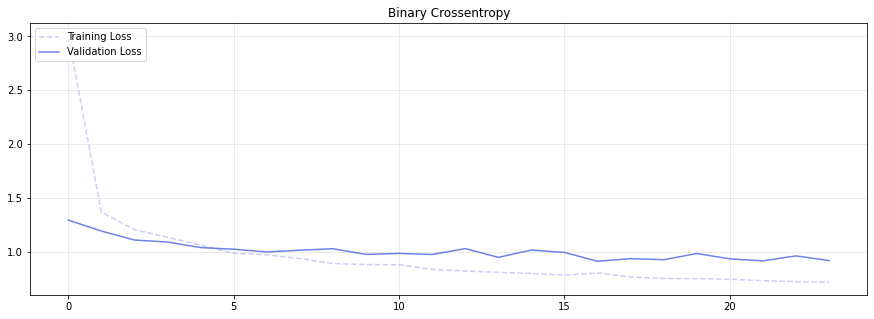

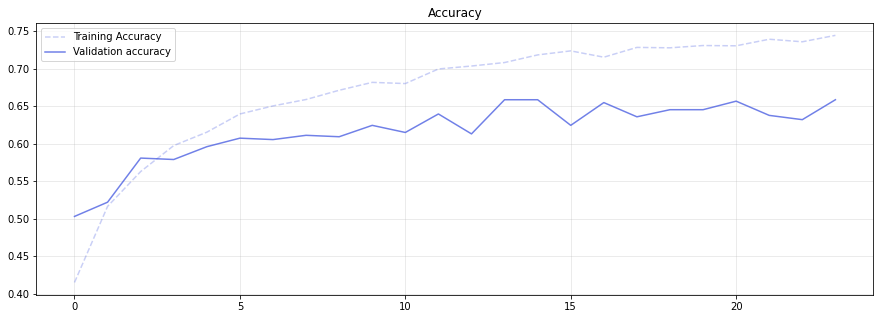

In [16]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [17]:
tl_model.save('Vgg16/FineFineTuning_v1')

In [18]:
tl_model = tfk.models.load_model('Vgg16/FineFineTuning_v1')
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 256)               1179904   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 Output (Dense)              (None, 8)                 2056  

In [19]:
tl_model.get_layer('vgg16').trainable = True
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [20]:
for i, layer in enumerate(tl_model.get_layer('vgg16').layers[:13]):
  layer.trainable=False
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)
tl_model.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         

In [21]:
tl_model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [22]:
# Fine-tune the model
tl_history = tl_model.fit(
    x = aug_train_gen ,
    batch_size = 32,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=2 , restore_best_weights=True)],
    #class_weight = class_weight
).history

Epoch 1/200
175/175 [==============================] - 26s 139ms/step - loss: 1.0918 - accuracy: 0.6223 - precision_1: 0.7214 - recall_1: 0.4943 - val_loss: 0.9269 - val_accuracy: 0.6736 - val_precision_1: 0.7751 - val_recall_1: 0.5560
Epoch 2/200
175/175 [==============================] - 24s 135ms/step - loss: 0.8400 - accuracy: 0.7038 - precision_1: 0.7892 - recall_1: 0.6109 - val_loss: 0.8242 - val_accuracy: 0.7135 - val_precision_1: 0.7775 - val_recall_1: 0.6433
Epoch 3/200
175/175 [==============================] - 24s 135ms/step - loss: 0.6415 - accuracy: 0.7746 - precision_1: 0.8463 - recall_1: 0.6989 - val_loss: 0.6873 - val_accuracy: 0.7495 - val_precision_1: 0.8197 - val_recall_1: 0.6641
Epoch 4/200
175/175 [==============================] - 24s 136ms/step - loss: 0.5600 - accuracy: 0.8054 - precision_1: 0.8650 - recall_1: 0.7437 - val_loss: 0.7307 - val_accuracy: 0.7704 - val_precision_1: 0.8140 - val_recall_1: 0.7059
Epoch 5/200
175/175 [==============================] - 2

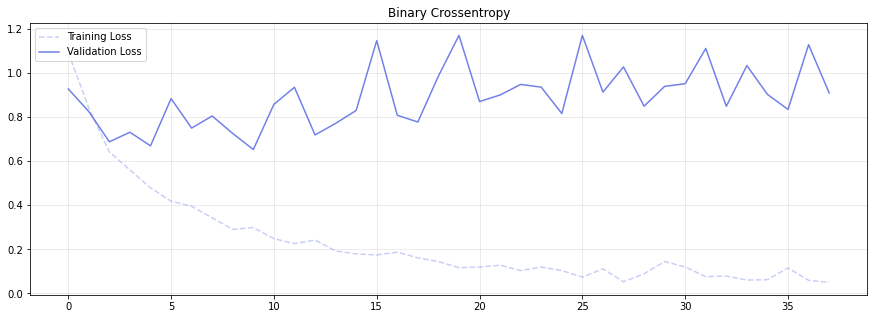

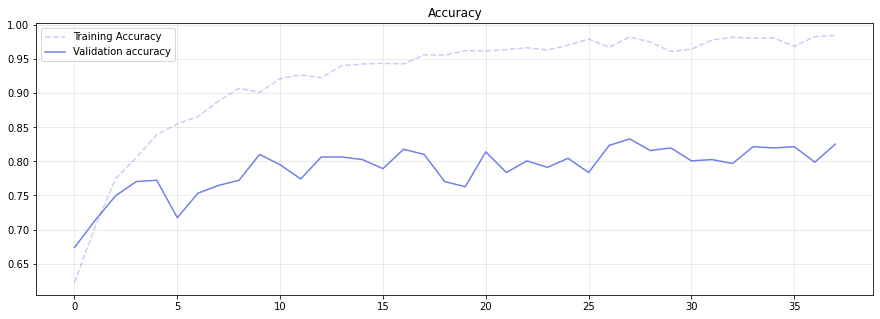

In [23]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [24]:
%cd /gdrive/My Drive/ANDL/Homework_1

/gdrive/My Drive/ANDL/Homework_1


In [25]:
tl_model.save('Vgg16/Tuned_v1_1')

In [26]:
tl_model.save('Vgg16/layers_13')

In [27]:
# Test the model
tl_model = tfk.models.load_model("Vgg16/Tuned_v1_1")
model_test_metrics = tl_model.evaluate(test_gen, return_dict=True)

print()
print("Test metrics")
print(model_test_metrics)

12/12 [==============================] - 2s 98ms/step - loss: 0.9122 - accuracy: 0.8366 - precision_1: 0.8531 - recall_1: 0.8366

Test metrics
{'loss': 0.9122076034545898, 'accuracy': 0.8365650773048401, 'precision_1': 0.8531073331832886, 'recall_1': 0.8365650773048401}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


Accuracy: 0.8366
Precision: 0.8208
Recall: 0.8228
F1: 0.8196


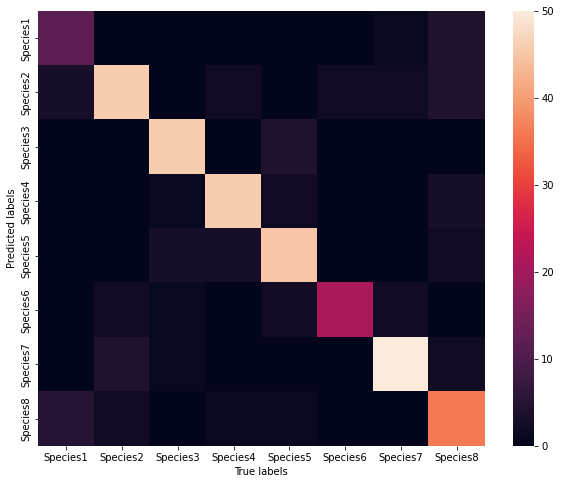

In [28]:
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

predictions = tl_model.predict_generator(test_gen, steps=224)
predicted_classes = np.argmax(predictions, axis=-1)

# Compute the confusion matrix
cm = (confusion_matrix(test_gen.classes, predicted_classes))

# Compute the classification metrics
accuracy = accuracy_score(test_gen.classes, predicted_classes)
precision = precision_score(test_gen.classes, predicted_classes, average='macro')
recall = recall_score(test_gen.classes, predicted_classes, average='macro')
f1 = f1_score(test_gen.classes, predicted_classes, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()